# Validation of the model
In this file we will validate the model by comparing the results of Groningen with the results of another city in the Netherlands. In this file we will use two shapefiles one of Groningen and one of another city 


In [1]:
import pandas as pd
import geopandas as geopandas
import matplotlib.pyplot as plt
import numpy
import folium
from shapely.geometry import Point

In [2]:
shp_zip_codes = geopandas.read_file("GEO-data/georef-amsterdam-postcode-pc4.shp")[["pc4_code", "geometry"]]
shp_zip_codes.columns = ["Postcode", "geometry"]
# read data of the whole country
df_dabba_country = pd.read_excel("Dabba_Landelijk.xlsx", names=["Postcode", "DeliveryDate"], usecols="H,J")
df_dabba_country["Postcode"] = df_dabba_country["Postcode"].astype(str).apply(lambda x:x[:4]) # cut the last two characters
df_dabba_country['Deliveries'] = df_dabba_country['Postcode'].map(df_dabba_country['Postcode'].value_counts()) # calculate the deliveries per postcode 


In [3]:
# Filter all the postalcodes in the geoframe based on the postalcodes in the dabba dataframe
shp_zip_codes_amsterdam = shp_zip_codes[shp_zip_codes["Postcode"].isin(df_dabba_country["Postcode"].unique())]
# create area in km2 column
shp_zip_codes_amsterdam["Area (km2)"] = shp_zip_codes_amsterdam['geometry'].to_crs({'init': 'epsg:23095'}).map(lambda p: p.area / 10**6)

c:\Users\tobia\miniconda3\envs\lastmile\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\tobia\miniconda3\envs\lastmile\lib\site-packages\geopandas\geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [4]:
# merge dabba dataframe with the geoframe
df_amsterdam = pd.merge(df_dabba_country[["DeliveryDate", "Postcode", "Deliveries"]], shp_zip_codes_amsterdam, on="Postcode").drop_duplicates()

# #get the number of operational workdays 
working_days = len(df_amsterdam["DeliveryDate"].unique())
# calculate the route length approximation per entry
k = 0.92
n = df_amsterdam["Deliveries"] / working_days # take the total of all deliveries within and postalcode area and devided it by the amount of workingdays
A = df_amsterdam["Area (km2)"]
# the amount of cyclist needed all deliveries within an postcode area per working day
df_amsterdam["Number of cyclists"] = numpy.ceil(df_amsterdam["Deliveries"]/30)
m = numpy.ceil(df_amsterdam["Number of cyclists"] / working_days)

# Calculate and add Beardwood per postalcode area as new column in km
df_amsterdam["Beardwood approx"] = k * numpy.sqrt((n * A))
df_amsterdam

,DeliveryDate,Postcode,Deliveries,geometry,Area (km2),Number of cyclists,Beardwood approx
0,2021-10-11,1072,3533,"MULTIPOLYGON (((4.89981 52.35531, 4.89982 52.3...",0.609059,118.0,5.376742
38,2021-10-12,1072,3533,"MULTIPOLYGON (((4.89981 52.35531, 4.89982 52.3...",0.609059,118.0,5.376742
78,2021-10-13,1072,3533,"MULTIPOLYGON (((4.89981 52.35531, 4.89982 52.3...",0.609059,118.0,5.376742
115,2021-10-14,1072,3533,"MULTIPOLYGON (((4.89981 52.35531, 4.89982 52.3...",0.609059,118.0,5.376742
154,2021-10-15,1072,3533,"MULTIPOLYGON (((4.89981 52.35531, 4.89982 52.3...",0.609059,118.0,5.376742
...,...,...,...,...,...,...,...
29494,2021-11-04,1016,2,"MULTIPOLYGON (((4.89070 52.37418, 4.89066 52.3...",0.804098,1.0,0.146990
29495,2021-11-05,1016,2,"MULTIPOLYGON (((4.89070 52.37418, 4.89066 52.3...",0.804098,1.0,0.146990
29496,2021-12-01,1076,1,"POLYGON ((4.86577 52.35150, 4.86581 52.35145, ...",1.394135,1.0,0.136858
29497,2021-12-03,1075,1,"POLYGON ((4.86591 52.35983, 4.86667 52.35852, ...",1.055752,1.0,0.119096


## Validation results
Get the results of the city of Amsterdam and check if the model creates the same behaviour as in Groningen. Lets start with Beardwood's approximation for Amsterdam city in the Netherlands. 

In [6]:
results_amsterdam = geopandas.GeoDataFrame(df_amsterdam[["Postcode", "Deliveries", "Area (km2)", "Number of cyclists", "Beardwood approx"]], geometry=df_amsterdam["geometry"]).drop_duplicates()
results_amsterdam.set_crs(epsg=4326, inplace=True)

,Postcode,Deliveries,Area (km2),Number of cyclists,Beardwood approx,geometry
0,1072,3533,0.609059,118.0,5.376742,"MULTIPOLYGON (((4.89981 52.35531, 4.89982 52.3..."
3533,1097,1645,2.849895,55.0,7.936243,"POLYGON ((4.92853 52.35640, 4.92858 52.35634, ..."
5178,1079,2391,1.557319,80.0,7.072876,"POLYGON ((4.91308 52.34829, 4.91352 52.34676, ..."
7569,1071,3093,1.357798,104.0,7.511473,"MULTIPOLYGON (((4.86926 52.35463, 4.86918 52.3..."
10662,1077,1821,1.751723,61.0,6.546441,"POLYGON ((4.87544 52.35323, 4.87594 52.35314, ..."
12483,1017,2124,1.302557,71.0,6.096678,"POLYGON ((4.88842 52.36951, 4.88890 52.36914, ..."
14607,1096,1208,3.128321,41.0,7.125357,"POLYGON ((4.91678 52.34611, 4.91680 52.34608, ..."
15815,1074,1821,0.428220,61.0,3.236725,"POLYGON ((4.90606 52.35796, 4.90641 52.35718, ..."
17636,1012,1183,1.159886,40.0,4.293561,"POLYGON ((4.90362 52.38179, 4.90467 52.38148, ..."
18819,1011,1415,0.974775,48.0,4.304750,"POLYGON ((4.90562 52.37935, 4.90562 52.37935, ..."


In [ ]:
results_amsterdam.explore(
    column="Beardwood approx",
    tooltip=['Postcode', 'Area (km2)', 'Deliveries', "Beardwood approx"],
    popup=True,
    tiles="CartoDB positron", 
    cmap="OrRd", 
    name="Beardwood approximation per postalcode area Amsterdam"
) 

### Influence of depot locations in Amsterdam
Add depot locations and check the influence of those depots for the city of Amsterdam. 

In [8]:
lat_long_amsterdam = [52.37003267561365, 4.898141673326259] # starting location of the folium map
# 52.335365, 4.931324 location Cycloon fiets koerier Amsterdam
# Kinkerstraat Amsterdam: 52.365272216877884, 4.864477134327737
# Kardijks plein Amsterdam: 52.370838933577176, 4.913064233131087
# Gustav Mahlerlaan: 52.33667454464343, 4.871429350608954
depots_locations = [Point(4.931324, 52.335365), Point(4.864477134327737, 52.365272216877884), Point(4.913734812078237, 52.370771777865194), Point(4.871429350608954, 52.33667454464343)]

In [9]:
i = 0
for depot_location in depots_locations:
    distances = []
    for phane in results_amsterdam.geometry:
        geo_phane = geopandas.GeoSeries(phane)
        geo_phane.set_crs(23095, inplace=True)
        geo_point = geopandas.GeoSeries(depot_location)
        geo_point.set_crs(23095, inplace=True) 
        d = geo_phane.distance(geo_point).values[0] * 100
        distances.append(d)
    distances = numpy.array(distances) # calculate D
    # results["D_depot_{0}".format(i)] = distances
    results_amsterdam["T*_depot_{0}".format(i)] = (2*distances) + results_amsterdam["Beardwood approx"]
    i=i+1

In [10]:
# calculate the influence of multiple depots by taking per set of depot the mimimal distance per postcode area
results_amsterdam["2_depots"] = results_amsterdam[["T*_depot_0", "T*_depot_1"]].min(axis=1)
results_amsterdam["3_depots"] = results_amsterdam[["T*_depot_0", "T*_depot_1", "T*_depot_2"]].min(axis=1)
results_amsterdam["4_depots"] = results_amsterdam[["T*_depot_0", "T*_depot_1", "T*_depot_2", "T*_depot_3"]].min(axis=1)

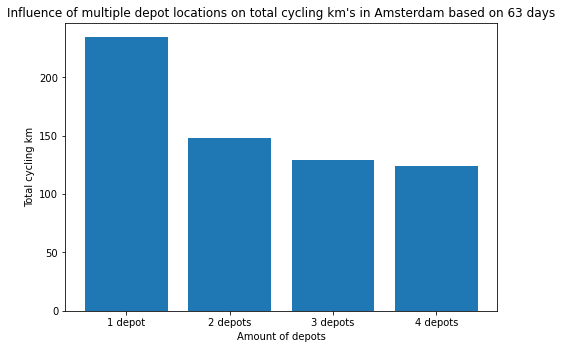

In [12]:
depot_1 = sum(results_amsterdam["T*_depot_0"]) 
depot_2 = sum(results_amsterdam["2_depots"]) 
depot_3 = sum(results_amsterdam["3_depots"]) 
depot_4 = sum(results_amsterdam["4_depots"]) 
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
depots = ["1 depot", "2 depots", "3 depots", "4 depots"]
sum_route_length_per_depot = [depot_1, depot_2, depot_3, depot_4]
ax.bar(depots,sum_route_length_per_depot)

plt.title("Influence of multiple depot locations on total cycling km's in Amsterdam based on {0} days".format(working_days))
plt.xlabel("Amount of depots")
plt.ylabel("Total cycling km")
plt.show()

In [14]:
results_amsterdam[["Postcode","T*_depot_0","2_depots", "3_depots", "4_depots"]]

,Postcode,T*_depot_0,2_depots,3_depots,4_depots
0,1072,12.829616,9.941487,9.536105,9.536105
38,1072,12.829616,9.941487,9.536105,9.536105
78,1072,12.829616,9.941487,9.536105,9.536105
115,1072,12.829616,9.941487,9.536105,9.536105
154,1072,12.829616,9.941487,9.536105,9.536105
...,...,...,...,...,...
29494,1016,11.114274,2.570610,2.570610,2.570610
29495,1016,11.114274,2.570610,2.570610,2.570610
29496,1076,12.615734,2.817222,2.817222,2.438372
29497,1075,12.761397,1.202818,1.202818,1.202818


In [29]:
# create function for creating a map 
def create_map(map_start_location, depot_locations, results, depot_amount):
    m = folium.Map(location=map_start_location, zoom_start=12, tiles="CartoDB positron")

    for i in range(len(depot_locations)):
        if i > depot_amount:
            break
        folium.Marker(
                [depots_locations[i].y, depots_locations[i].x], 
                popup="Depot_{0}".format(i+1),
                icon=folium.Icon(color='cadetblue', icon='solid fa-bicycle', prefix='fa')).add_to(m)
    
    depot_column_name = ""
    if depot_amount == 0:  
        depot_column_name = "T*_depot_{0}".format(depot_amount) 
    else: 
        depot_column_name = "{0}_depots".format(depot_amount+1)

    bins = list(results[depot_column_name].quantile([0, 0.25, 0.5, 0.75, 1]))

    choropleth = folium.Choropleth(
        results, 
        data=results, 
        key_on='feature.properties.Postcode', 
        columns=["Postcode", depot_column_name], 
        fill_color="OrRd",
        fill_opacity = 0.8,
        line_opacity = 1,
        line_weight=1,
        bins=bins,
        legend_name = "T* per postalcode area based on {0}".format(depot_column_name),
        name="T* of {0} per Postalcode area".format(depot_column_name)).add_to(m)

    choropleth.geojson.add_child(
        folium.features.GeoJsonTooltip(fields=['Postcode', "Deliveries", "Area (km2)", "Number of cyclists", "Beardwood approx", depot_column_name], labels=True)
    )
    m.save("{0}depots_amsterdam.html".format(depot_amount+1))
    folium.LayerControl().add_to(m)
    # return m

### Amsterdam results with 1 depot
Current situation 1 depot at Cycloon Amsterdam 

In [30]:
create_map(lat_long_amsterdam, depots_locations, results_amsterdam, 0)

### Amsterdam results with 2 depots
Two depot at Cycloon, Amsterdam and Kinkerstraat, Amsterdam

In [31]:
create_map(lat_long_amsterdam, depots_locations, results_amsterdam, 1)

### Amsterdam results with 3 depots
Three depots at:
- Cycloon fiets koerier
- Kinkerstraat
- Kardijks plein

In [32]:
create_map(lat_long_amsterdam, depots_locations, results_amsterdam, 2)

### Amsterdam results with 4 depots
Three depots at:
- Cycloon fiets koerier
- Kinkerstraat
- Kardijks plein
- Van Nijenrode weg

In [33]:
create_map(lat_long_amsterdam, depots_locations, results_amsterdam, 3)

In [28]:
excel_export = results_amsterdam.drop_duplicates()
excel_export.sort_values(by="Postcode", inplace=True)
excel_export.to_excel("results_amsterdam.xlsx")